In [1]:
# ✅ 1. Install required libraries and prepare Kaggle API
!pip install -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
uploaded = files.upload()  # Upload kaggle.json

with open("kaggle.json", "wb") as f:
    f.write(uploaded["kaggle.json"])
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# ✅ 2. Download and unzip dataset
!kaggle datasets download -d stoicstatic/face-recognition-dataset
!unzip -q face-recognition-dataset.zip -d FaceData

# ✅ 3. Check image files
import os

def count_images(data_root):
    exts = [".jpg", ".jpeg", ".png"]
    all_images = []
    for root, _, files in os.walk(data_root):
        for file in files:
            if any(file.lower().endswith(ext) for ext in exts):
                all_images.append(os.path.join(root, file))
    return all_images

all_images = count_images("FaceData")
print(f"✅ Total images found: {len(all_images)}")
print("📸 Sample image path:", all_images[0] if all_images else "None")


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/stoicstatic/face-recognition-dataset
License(s): CC0-1.0
 67% 122M/181M [00:00<00:00, 1.27GB/s]
100% 181M/181M [00:00<00:00, 971MB/s] 
✅ Total images found: 14311
📸 Sample image path: FaceData/Face Data/Face Dataset/670/0.jpg


In [2]:
import os
import random
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Dataset root path (adjust if needed)
DATA_ROOT = "FaceData/Face Data/Face Dataset"

# Image transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

# Helper: Load image with PIL and apply transform
def load_image(path):
    image = Image.open(path).convert("RGB")
    return transform(image)

# Build dictionary {person_id: [list of image paths]}
def build_image_dict(root):
    img_dict = {}
    for person_id in os.listdir(root):
        person_path = os.path.join(root, person_id)
        if os.path.isdir(person_path):
            imgs = [os.path.join(person_path, f) for f in os.listdir(person_path) if f.endswith(".jpg")]
            if len(imgs) >= 2:  # only keep if 2+ images for pair/triplet sampling
                img_dict[person_id] = imgs
    return img_dict

img_dict = build_image_dict(DATA_ROOT)

print(f"Number of persons with >=2 images: {len(img_dict)}")

# === Dataset for Binary Cross-Entropy and Contrastive Loss (Pairs) ===
class PairDataset(Dataset):
    def __init__(self, img_dict):
        self.img_dict = img_dict
        self.persons = list(img_dict.keys())

    def __len__(self):
        # Define length arbitrarily, e.g. number of pairs sampled per epoch
        return 10000

    def __getitem__(self, idx):
        # 50% positive pairs, 50% negative pairs
        if random.random() < 0.5:
            # Positive pair (same person)
            person = random.choice(self.persons)
            imgs = self.img_dict[person]
            img1, img2 = random.sample(imgs, 2)
            label = 1
        else:
            # Negative pair (different persons)
            person1, person2 = random.sample(self.persons, 2)
            img1 = random.choice(self.img_dict[person1])
            img2 = random.choice(self.img_dict[person2])
            label = 0

        img1 = load_image(img1)
        img2 = load_image(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

# === Dataset for Triplet Loss ===
class TripletDataset(Dataset):
    def __init__(self, img_dict):
        self.img_dict = img_dict
        self.persons = list(img_dict.keys())

    def __len__(self):
        return 10000

    def __getitem__(self, idx):
        anchor_person = random.choice(self.persons)
        positive_imgs = self.img_dict[anchor_person]
        negative_person = random.choice([p for p in self.persons if p != anchor_person])
        negative_imgs = self.img_dict[negative_person]

        anchor = load_image(random.choice(positive_imgs))
        positive = load_image(random.choice(positive_imgs))
        negative = load_image(random.choice(negative_imgs))

        return anchor, positive, negative

# === Simple CNN Backbone ===
class SimpleCNN(nn.Module):
    def __init__(self, embedding_size=128):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
        )
        self.fc = nn.Linear(128 * 8 * 8, embedding_size)

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        x = nn.functional.normalize(x, p=2, dim=1)  # Normalize embeddings
        return x

# === Face Verifier for BCE Loss ===
class BCEVerifier(nn.Module):
    def __init__(self, embedding_net):
        super(BCEVerifier, self).__init__()
        self.embedding_net = embedding_net
        self.fc = nn.Sequential(
            nn.Linear(embedding_net.fc.out_features * 2, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        emb1 = self.embedding_net(x1)
        emb2 = self.embedding_net(x2)
        combined = torch.cat([emb1, emb2], dim=1)
        out = self.fc(combined)
        return out.squeeze()

# === Contrastive Loss Function ===
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, emb1, emb2, label):
        dist = (emb1 - emb2).pow(2).sum(1)
        loss = label * dist + (1 - label) * torch.clamp(self.margin - dist.sqrt(), min=0).pow(2)
        return loss.mean()

# === Triplet Loss Function ===
triplet_loss_fn = nn.TripletMarginLoss(margin=1.0)

# === Setup Datasets and DataLoaders ===
batch_size = 64

pair_dataset = PairDataset(img_dict)
triplet_dataset = TripletDataset(img_dict)

pair_loader = DataLoader(pair_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
triplet_loader = DataLoader(triplet_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# === Initialize Models ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_net_bce = SimpleCNN().to(device)
embedding_net_contrastive = SimpleCNN().to(device)
embedding_net_triplet = SimpleCNN().to(device)

bce_verifier = BCEVerifier(embedding_net_bce).to(device)

# === Optimizers ===
optimizer_bce = optim.Adam(bce_verifier.parameters(), lr=1e-3)
optimizer_contrastive = optim.Adam(embedding_net_contrastive.parameters(), lr=1e-3)
optimizer_triplet = optim.Adam(embedding_net_triplet.parameters(), lr=1e-3)

# === Losses ===
bce_loss_fn = nn.BCELoss()
contrastive_loss_fn = ContrastiveLoss()

# === Training Functions ===
def train_bce_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for x1, x2, label in loader:
        x1, x2, label = x1.to(device), x2.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(x1, x2)
        loss = bce_loss_fn(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def train_contrastive_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for x1, x2, label in loader:
        x1, x2, label = x1.to(device), x2.to(device), label.to(device)
        optimizer.zero_grad()
        emb1 = model(x1)
        emb2 = model(x2)
        loss = contrastive_loss_fn(emb1, emb2, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def train_triplet_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for anchor, positive, negative in loader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        optimizer.zero_grad()
        emb_anchor = model(anchor)
        emb_positive = model(positive)
        emb_negative = model(negative)
        loss = triplet_loss_fn(emb_anchor, emb_positive, emb_negative)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)




Number of persons with >=2 images: 1680


Epoch 1: BCE Loss=0.6932 | Contrastive Loss=0.2115 | Triplet Loss=0.4694
Epoch 2: BCE Loss=0.6931 | Contrastive Loss=0.1773 | Triplet Loss=0.3740
Epoch 3: BCE Loss=0.6930 | Contrastive Loss=0.1579 | Triplet Loss=0.3392
Epoch 4: BCE Loss=0.6933 | Contrastive Loss=0.1412 | Triplet Loss=0.3061
Epoch 5: BCE Loss=0.6932 | Contrastive Loss=0.1262 | Triplet Loss=0.2847


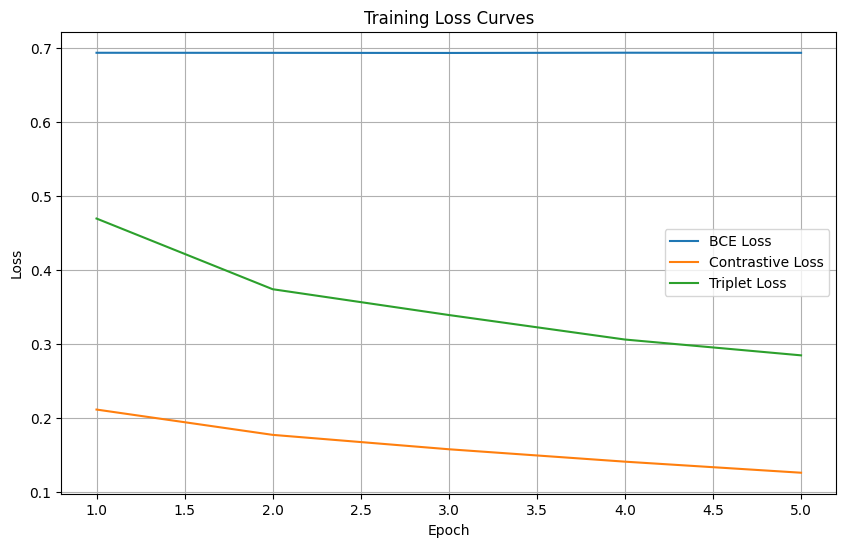

In [4]:
import matplotlib.pyplot as plt

# Prepare lists to store loss values during training
losses_bce = []
losses_contrastive = []
losses_triplet = []

epochs = 5
for epoch in range(1, epochs + 1):
    loss_bce = train_bce_epoch(bce_verifier, pair_loader, optimizer_bce)
    loss_contrastive = train_contrastive_epoch(embedding_net_contrastive, pair_loader, optimizer_contrastive)
    loss_triplet = train_triplet_epoch(embedding_net_triplet, triplet_loader, optimizer_triplet)

    losses_bce.append(loss_bce)
    losses_contrastive.append(loss_contrastive)
    losses_triplet.append(loss_triplet)

    print(f"Epoch {epoch}: BCE Loss={loss_bce:.4f} | Contrastive Loss={loss_contrastive:.4f} | Triplet Loss={loss_triplet:.4f}")

# Plot losses
plt.figure(figsize=(10,6))
plt.plot(range(1, epochs + 1), losses_bce, label='BCE Loss')
plt.plot(range(1, epochs + 1), losses_contrastive, label='Contrastive Loss')
plt.plot(range(1, epochs + 1), losses_triplet, label='Triplet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.grid(True)
plt.show()
